# Exploring data formats

In [1]:
!ls -lh data/

total 7190368
-rw-------@ 1 fobermey  staff    50K Aug 30 21:22 County_8_11_2020.csv
-rw-------@ 1 fobermey  staff   3.4G Aug 30 21:29 GTR4G_posterior.trees
-r--------  0 fobermey  staff     0B Dec 31  1969 Icon?
-rw-------@ 1 fobermey  staff   172B Sep  2 09:04 README.md
-rw-------@ 1 fobermey  staff   4.5K Aug 31 09:39 demographics_by_zip_2013_ACS.tsv
-rw-------@ 1 fobermey  staff    20K Sep  2 08:59 ma_zip_county.csv
-rw-------@ 1 fobermey  staff    16K Aug 30 21:24 sample_county.tsv
-rw-------@ 1 fobermey  staff    46K Aug 30 21:24 trimmed_alignment.fasta_ML_tree_from_iqtree.contree


- `GTR4G_posterior.trees` appears to be in NEXUS format
- `trimmed_alignment.fasta_ML_tree_from_iqtree.cont` appears to be in Newick format

In [2]:
import pandas as pd
from Bio import Phylo
import matplotlib.pyplot as plt

## Incidence time series

In [3]:
incidence_df = pd.read_csv("data/County_8_11_2020.csv")
incidence_df.head()

,Date,County,Count,Deaths
0,4/17/2020,Barnstable,582.0,NaN
1,4/17/2020,Berkshire,390.0,NaN
2,4/17/2020,Bristol,1693.0,NaN
3,4/17/2020,Dukes,14.0,NaN
4,4/17/2020,Essex,4668.0,NaN


In [4]:
print(sorted(set(incidence_df["County"])))

['Barnstable', 'Berkshire', 'Bristol', 'Dukes', 'Dukes and Nantucket', 'Essex', 'Franklin', 'Hampden', 'Hampshire', 'Middlesex', 'Nantucket', 'Norfolk', 'Plymouth', 'Suffolk', 'Unknown', 'Worcester']


Text(0, 0.5, 'cumulative cases')

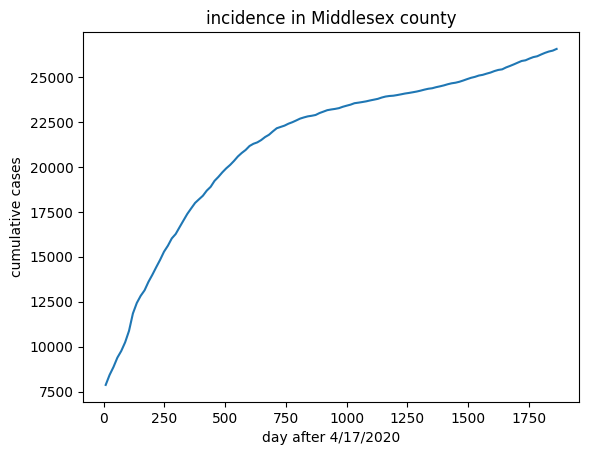

In [5]:
county = "Middlesex"
df = incidence_df[incidence_df["County"] == county]
plt.plot(df["Count"])
plt.title(f"incidence in {county} county")
plt.xlabel("day after {}".format(df["Date"].min()))
plt.ylabel("cumulative cases")

## Genetic samples

In [6]:
sample_df = pd.read_csv("data/sample_county.tsv", sep="\t")
sample_df.head()

,sample_id,county
0,MA_MGH_00003,Middlesex
1,MA_MGH_00004,Middlesex
2,MA_MGH_00005,Norfolk
3,MA_MGH_00006,Suffolk
4,MA_MGH_00013,Middlesex


In [7]:
print(set(sample_df["county"]))

{'Middlesex', nan, 'Bristol', 'Essex', 'Plymouth', 'Nantucket', 'Worcester', 'Norfolk', 'Barnstable', 'Berkshire', 'Suffolk'}


In [8]:
sample_df["county"].isna().sum()

76

## Demographic data

In [9]:
demo_df = pd.read_csv("data/demographics_by_zip_2013_ACS.tsv", sep="\t")
print(len(demo_df))
demo_df.head()

116


,region,value1,total_population,percent_white,percent_black,percent_asian,percent_hispanic,per_capita_income,median_rent,median_age
0,1704,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1719,1,5048.0,81.0,0.0,17.0,1.0,61461.0,842.0,43.7
2,1730,4,13649.0,81.0,2.0,12.0,4.0,48886.0,1445.0,43.9
3,1748,1,15271.0,92.0,0.0,5.0,2.0,56899.0,1165.0,39.5
4,1752,1,38842.0,75.0,2.0,5.0,11.0,35335.0,977.0,39.5


## Phylogenetic trees

In [10]:
ml_tree = Phylo.read("data/trimmed_alignment.fasta_ML_tree_from_iqtree.contree",
                     format="newick")
ml_tree.count_terminals()

772

The posterior tree file is too large for ``Bio.Phylo``, so we implement a custom parser.

In [11]:
from pyrophylo.io import read_nexus_trees
posterior_trees = read_nexus_trees("data/GTR4G_posterior.trees", format="newick",
                                   max_num_trees=10)

In [12]:
tree = next(posterior_trees)
tree.count_terminals()

772

We also implement a custom conversion to PyTorch. To convert all trees once, run
```sh
python preprocess_trees.py
```
This takes about 6 minues on my laptop.

We can then load the trees as a batched ``Phylogeny`` object.

In [13]:
!ls -lh results/

total 4822712
-rw-r--r--  1 fobermey  staff   2.3G Sep  1 17:42 GTR4G_posterior.pt


In [14]:
import torch
phylo = torch.load("results/GTR4G_posterior.pt")

In [15]:
print(type(phylo))
print(len(phylo))
print(phylo.batch_shape)
print(phylo.num_nodes)
print(phylo.num_leaves)

<class 'pyrophylo.phylo.Phylogeny'>
100001
torch.Size([100001])
1543
772


## Zip code <--> county mapping

It looks like we'll need a mapping between counties and zip codes.

In [16]:
zip_county_df = pd.read_csv("data/ma_zip_county.csv")
zip_county_df.head()

,zip,city,county,pop
0,2301,Brockton,Plymouth,62929
1,2148,Malden,Middlesex,61354
2,2155,Medford,Middlesex,59793
3,2360,Plymouth,Plymouth,59133
4,2169,Quincy,Norfolk,56584


In [17]:
zip_to_county = dict(zip(zip_county_df["zip"], zip_county_df["county"]))
print(sorted(set(zip_to_county.values())))

['Barnstable', 'Berkshire', 'Bristol', 'Dukes', 'Essex', 'Franklin', 'Hampden', 'Hampshire', 'Middlesex', 'Nantucket', 'Norfolk', 'Plymouth', 'Suffolk', 'Worcester']


Let's try to use the `demo_df` to assess county population.

In [18]:
county_populations = {name: 0 for name in set(zip_county_df["county"])}
for zip_code, pop in zip(demo_df["region"], demo_df["total_population"]):
    if pop > 0 and zip_code in zip_to_county:
        county = zip_to_county[zip_code]
        county_populations[county] += int(pop)
print(county_populations)

{'Plymouth': 107805, 'Essex': 407812, 'Middlesex': 984284, 'Bristol': 13932, 'Hampden': 0, 'Nantucket': 9843, 'Worcester': 0, 'Franklin': 0, 'Norfolk': 415337, 'Hampshire': 0, 'Dukes': 0, 'Barnstable': 17709, 'Berkshire': 0, 'Suffolk': 616804}


It looks like that is missing some counties. Let's instead use `ma_zip_county.csv` directly.

In [19]:
from collections import defaultdict
county_populations = defaultdict(int)
for county, pop in zip(zip_county_df["county"], zip_county_df["pop"]):
    county_populations[county] += pop
county_populations = dict(county_populations)
print(county_populations)

{'Plymouth': 509471, 'Middlesex': 1608039, 'Norfolk': 690173, 'Suffolk': 786312, 'Essex': 781354, 'Bristol': 558905, 'Berkshire': 127328, 'Hampden': 468855, 'Worcester': 819950, 'Hampshire': 162548, 'Barnstable': 216362, 'Franklin': 70555, 'Nantucket': 11101, 'Dukes': 17305}
